In [19]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn as sk
import xgboost as xgb
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.ensemble as ensemble
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_validate, KFold
from tensorflow.keras.utils import to_categorical

In [20]:
df = pd.read_csv('../data/2024-07-15_p02_origami_combined.csv')

/tmp/ipykernel_87814/1671165863.py:1: DtypeWarning: Columns (717) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/2024-07-15_p02_origami_combined.csv')


In [21]:
# Clean the dat

# Declare label
label_confused = 'confused'
label_help = 'help'
label_both = 'both'
label_neither = 'neither'
label_either = 'either' # Help means you are confused and need help

labels = [label_confused, label_help, label_both, label_neither, label_either]

def clean(df):
    cols = ['body_tracking_error', 'confused', 'help']
    df = df.copy()

    # Define the patterns to filter out for body34
    patterns_to_remove_body34 = [
    r'keypoint_1[8-9]_.*',  # Matches keypoint_18_* and keypoint_19_*
    r'keypoint_2[0-5]_.*', # Matches keypoint_20_* to keypoint_29_*
    r'keypoint_3[2-3]_.*', # Matches keypoint_32_* to keypoint_33_*
    r'keypoint_confidence_1[8-9]',  # Matches keypoint_confidence_18 and keypoint_confidence_19
    r'keypoint_confidence_2[0-5]',  # Matches keypoint_confidence_20 to keypoint_confidence_29
    r'keypoint_confidence_3[2-3]', # Matches keypoint_confidence_32 to keypoint_confidence_33
    r'local_position_per_joint_1[8-9]_.*', # Matches local_position_per_joint_18_* and local_position_per_joint_19_*
    r'local_position_per_joint_2[0-5]_.*', # Matches local_position_per_joint_20_* to local_position_per_joint_29_*
    r'local_position_per_joint_3[2-3]_.*', # Matches local_position_per_joint_32_* to local_position_per_joint_33_*
    r'local_orientation_per_joint_1[8-9]_.*', # Matches local_orientation_per_joint_18_* and local_orientation_per_joint_19_*
    r'local_orientation_per_joint_2[0-5]_.*', # Matches local_orientation_per_joint_20_* to local_orientation_per_joint_29_*
    r'local_orientation_per_joint_3[2-3]_.*'  # Matches local_orientation_per_joint_32_* to local_orientation_per_joint_33_*
    ]

    # Combine patterns into a single regex pattern
    combined_pattern = '|'.join(patterns_to_remove_body34)

    # Filter columns based on the combined pattern
    filtered_columns = df.filter(regex=f'^((?!{combined_pattern}).)*$', axis=1)

    # Assign back to df
    df = df[filtered_columns.columns]

    # drop columns with NaN values in cols
    df = df.dropna(subset=cols)
    for col in cols:
        df[col] = df[col].replace(['False', 'True', '0.0', '1.0'], ['0', '1', '0', '1'])  # Replace string values with integers
        df[col] = df[col].astype('Int64')  # Use 'Int64' for nullable integers in pandas

    # Filter data based on confusion status
    df[label_both] = (df[label_confused] == 1) & (df[label_help] == 1)
    df[label_neither] = (df[label_confused] == 0) & (df[label_help] == 0)
    df[label_either] = (df[label_confused] == 1) | (df[label_help] == 1)
    df[label_confused] = (df[label_confused] == 1) & (df[label_help] == 0)
    df[label_help] = (df[label_help] == 1) & (df[label_confused] == 0)

    df = df[(df["body_tracking_error"] == 0)]

    #df = df.dropna()
    #return df[(df["body_tracking_error"] == 0) & (df["success"] == 1)]
    return df

def lost_metrics(df, df_filtered):
    # Lost Frames
    print("Original df: ", df.shape)
    print("Filtered df: ", df_filtered.shape)
    print("Lost Frames: ", df.shape[0] - df_filtered.shape[0])
    print()

    for label in labels:
        # Calculate the truth percentage of the total
        if label == label_neither:
            truth_percentage = (df_filtered[label].value_counts(normalize=True).get(0, 0)) * 100
        else:
            truth_percentage = (df_filtered[label].value_counts(normalize=True).get(1, 0)) * 100

        # Display the label and its truth percentage
        print(f'{label}: {truth_percentage:.2f}%')

        # Display the value counts for the label
        value_counts = df_filtered[label].value_counts()
        print(value_counts.to_string(), "\n")  # Converts the Series to a string to format it nicely

    try:
        # Display the shape of the DataFrame
        columns_with_nan = df_filtered.columns[df.isna().any()].tolist()

        # Calculate the number of NaN values for each column with NaNs
        nan_counts = df_filtered[columns_with_nan].isna().sum()

        # Create a bar plot for columns with NaN counts
        plt.figure(figsize=(12, 8))
        nan_counts.plot(kind='bar')
        plt.title('Number of NaN Values per Column')
        plt.xlabel('Columns')
        plt.ylabel('Number of NaN Values')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    except:
        print("No NaN values")


# Clean the data
df_filtered = clean(df)

In [22]:
# Summary statistics of numerical columns
summary_stats = df_filtered.describe()
print(summary_stats)

                 ts     timestamp         frame  face_id  confidence_x  \
count  18681.000000  18681.000000  18681.000000  18681.0  18681.000000   
mean     311.333313    311.333333   9341.000000      0.0      0.884051   
std      179.759116    179.762818   5392.884525      0.0      0.254396   
min        0.000000      0.000000      1.000000      0.0      0.000000   
25%      155.676000    155.667000   4671.000000      0.0      0.980000   
50%      311.318000    311.333000   9341.000000      0.0      0.980000   
75%      466.994000    467.000000  14011.000000      0.0      0.980000   
max      622.570000    622.667000  18681.000000      0.0      0.980000   

            success      gaze_0_x      gaze_0_y      gaze_0_z      gaze_1_x  \
count  18681.000000  18681.000000  18681.000000  18681.000000  18681.000000   
mean       0.903003      0.254268      0.218580     -0.810252      0.156054   
std        0.295962      0.123629      0.208205      0.274661      0.145167   
min        0.0000

In [23]:
df_filtered.head()

,ts,timestamp,frame,face_id,confidence_x,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,...,local_orientation_per_joint_30_3,local_orientation_per_joint_31_0,local_orientation_per_joint_31_1,local_orientation_per_joint_31_2,local_orientation_per_joint_31_3,confused,help,both,neither,either
0,0.000,0.000,1,0,0.98,1,0.250167,0.231496,-0.940120,0.096051,...,1.0,0.0,0.0,0.0,1.0,False,False,False,True,False
1,0.033,0.033,2,0,0.98,1,0.242963,0.228393,-0.942765,0.094555,...,1.0,0.0,0.0,0.0,1.0,False,False,False,True,False
2,0.067,0.067,3,0,0.98,1,0.243971,0.225870,-0.943112,0.097189,...,1.0,0.0,0.0,0.0,1.0,False,False,False,True,False
3,0.100,0.100,4,0,0.98,1,0.240007,0.224554,-0.944443,0.095567,...,1.0,0.0,0.0,0.0,1.0,False,False,False,True,False
4,0.134,0.133,5,0,0.98,1,0.240607,0.223447,-0.944553,0.096990,...,1.0,0.0,0.0,0.0,1.0,False,False,False,True,False


In [24]:
df['timestamp'] = df['timestamp'] / 1000

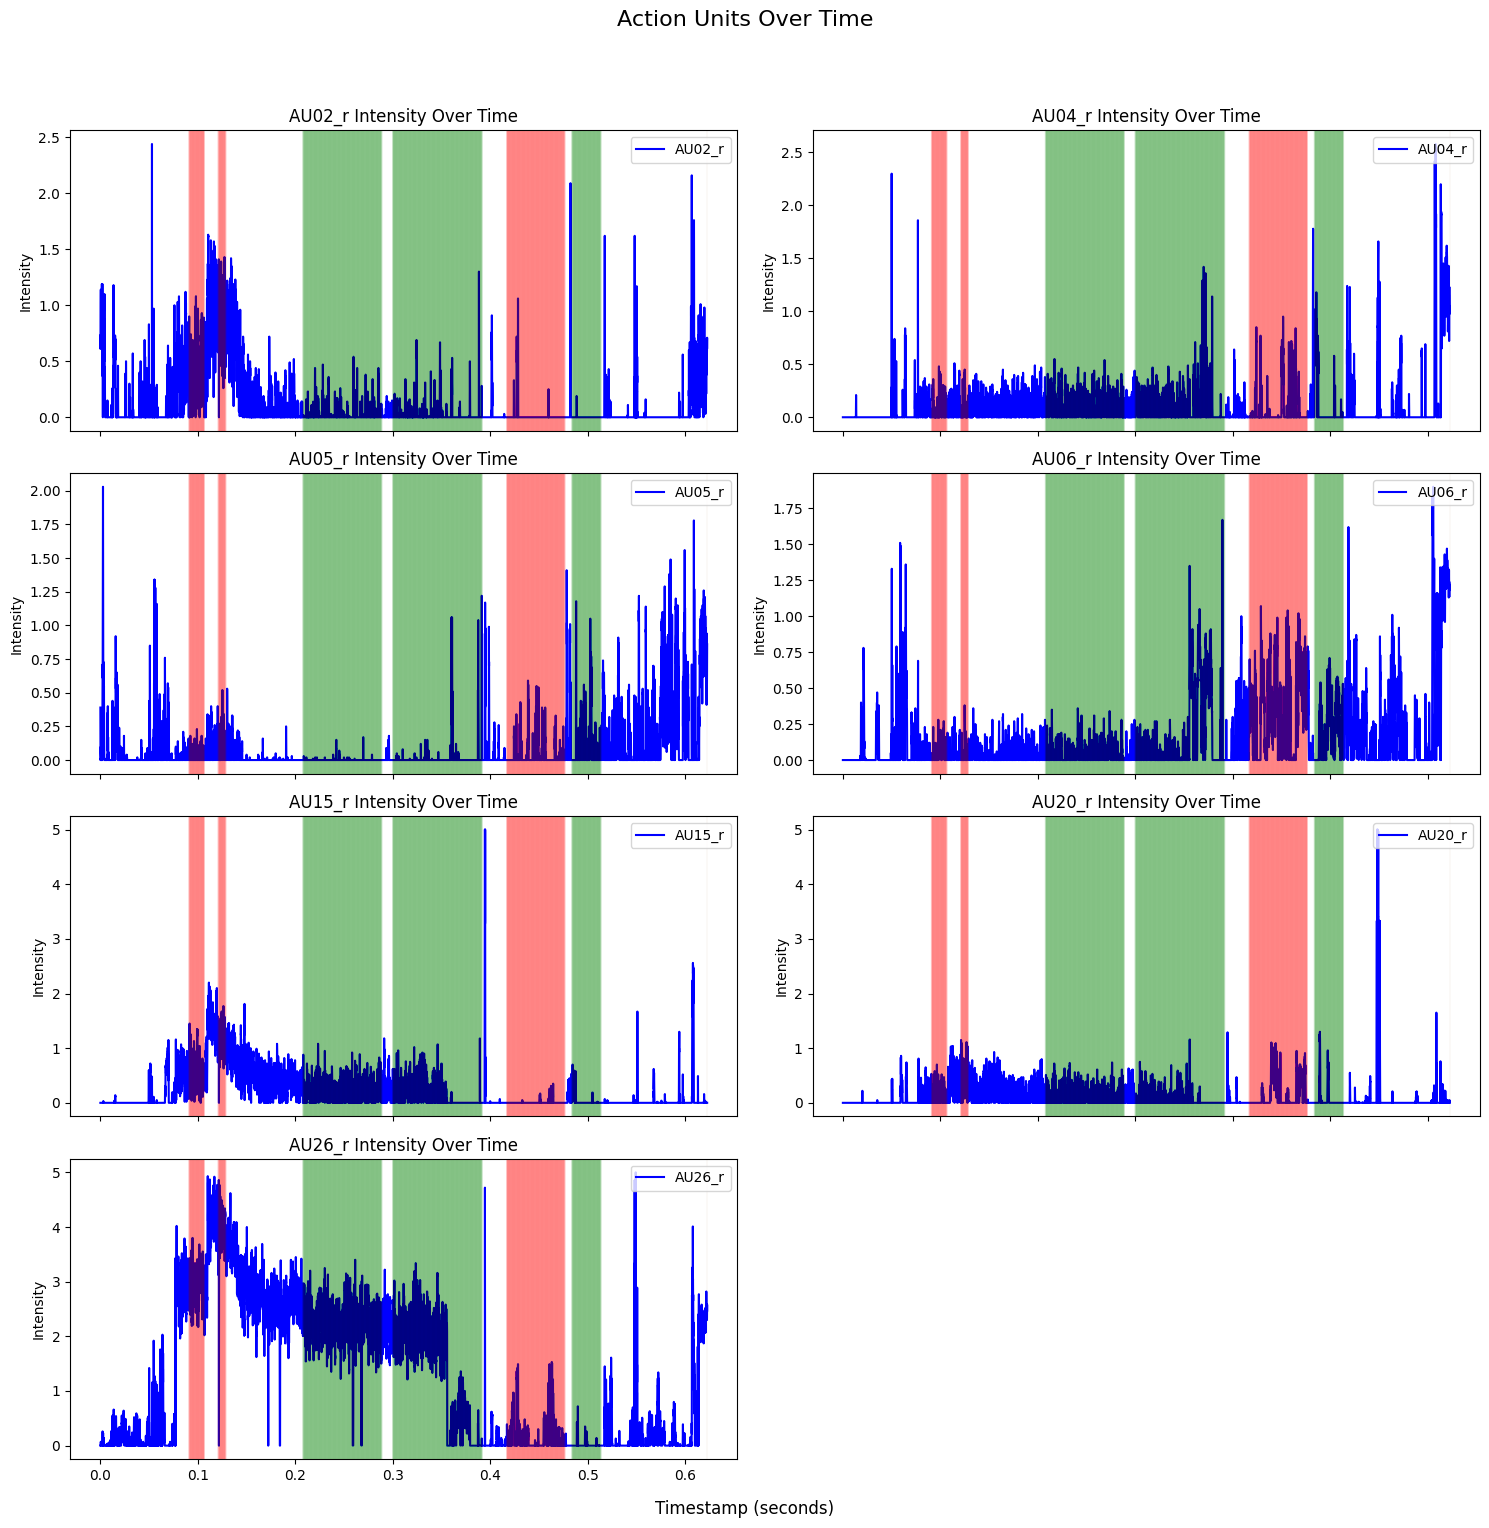

In [30]:
import math

# Convert 'confused' and 'help' columns to boolean if they are not already
df['confused'] = df['confused'].astype(bool)
df['help'] = df['help'].astype(bool)

# List of specific AUs to focus on
au_numbers = [2, 4, 5, 6, 15, 20, 26, 28]
au_columns = [f'AU{str(num).zfill(2)}_r' for num in au_numbers]

# Filter out AUs that may not be in the DataFrame
available_au_columns = [col for col in au_columns if col in df.columns]

# Convert 'confused' and 'help' columns to boolean if they are not already
df['confused'] = df['confused'].astype(bool)
df['help'] = df['help'].astype(bool)

# Extract timestamps for 'confused' and 'help' periods
confused_times = df[df['confused']]['timestamp']
help_times = df[df['help']]['timestamp']

# Set up the subplot grid
num_aus = len(available_au_columns)
cols = 2  # Number of columns in the subplot grid
rows = math.ceil(num_aus / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4), sharex=True)

# Flatten axes array for easy indexing
axes = axes.flatten()

for idx, au in enumerate(available_au_columns):
    ax = axes[idx]
    ax.plot(df['timestamp'], df[au], label=au, color='blue')
    ax.set_title(f'{au} Intensity Over Time')

    # Highlight 'confused' periods
    for t in confused_times:
        ax.axvline(x=t, color='red', alpha=0.007)

    # Highlight 'help' periods
    for t in help_times:
        ax.axvline(x=t, color='green', alpha=0.007)

    ax.set_ylabel('Intensity')
    ax.legend(loc='upper right')

# Remove any unused subplots
for idx in range(num_aus, len(axes)):
    fig.delaxes(axes[idx])

fig.text(0.5, 0.04, 'Timestamp (seconds)', ha='center', fontsize=12)
fig.suptitle('Action Units Over Time', fontsize=16)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


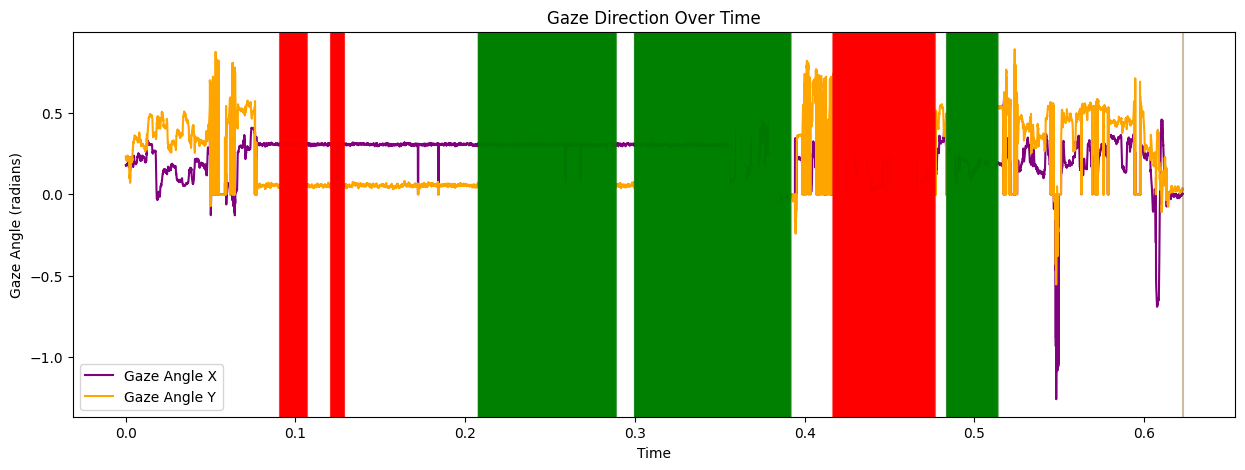

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['gaze_angle_x'], label='Gaze Angle X', color='purple')
plt.plot(df['timestamp'], df['gaze_angle_y'], label='Gaze Angle Y', color='orange')
plt.xlabel('Time')
plt.ylabel('Gaze Angle (radians)')
plt.title('Gaze Direction Over Time')
plt.legend()

# Highlight 'confused' periods
for idx, row in df[df['confused']].iterrows():
    plt.axvline(x=row['timestamp'], color='red', alpha=0.1)

# Highlight 'help' periods
for idx, row in df[df['help']].iterrows():
    plt.axvline(x=row['timestamp'], color='green', alpha=0.1)

plt.show()


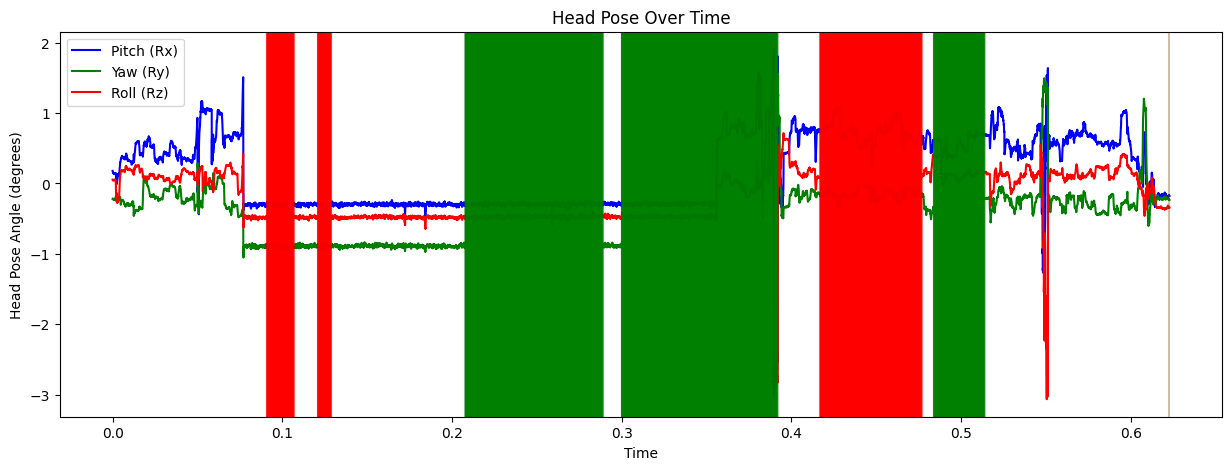

In [38]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['pose_Rx'], label='Pitch (Rx)', color='blue')
plt.plot(df['timestamp'], df['pose_Ry'], label='Yaw (Ry)', color='green')
plt.plot(df['timestamp'], df['pose_Rz'], label='Roll (Rz)', color='red')
plt.xlabel('Time')
plt.ylabel('Head Pose Angle (degrees)')
plt.title('Head Pose Over Time')
plt.legend()

# Highlight 'confused' and 'help' periods as above
for idx, row in df[df['confused']].iterrows():
    plt.axvline(x=row['timestamp'], color='red', alpha=0.1)

for idx, row in df[df['help']].iterrows():
    plt.axvline(x=row['timestamp'], color='green', alpha=0.1)

plt.show()


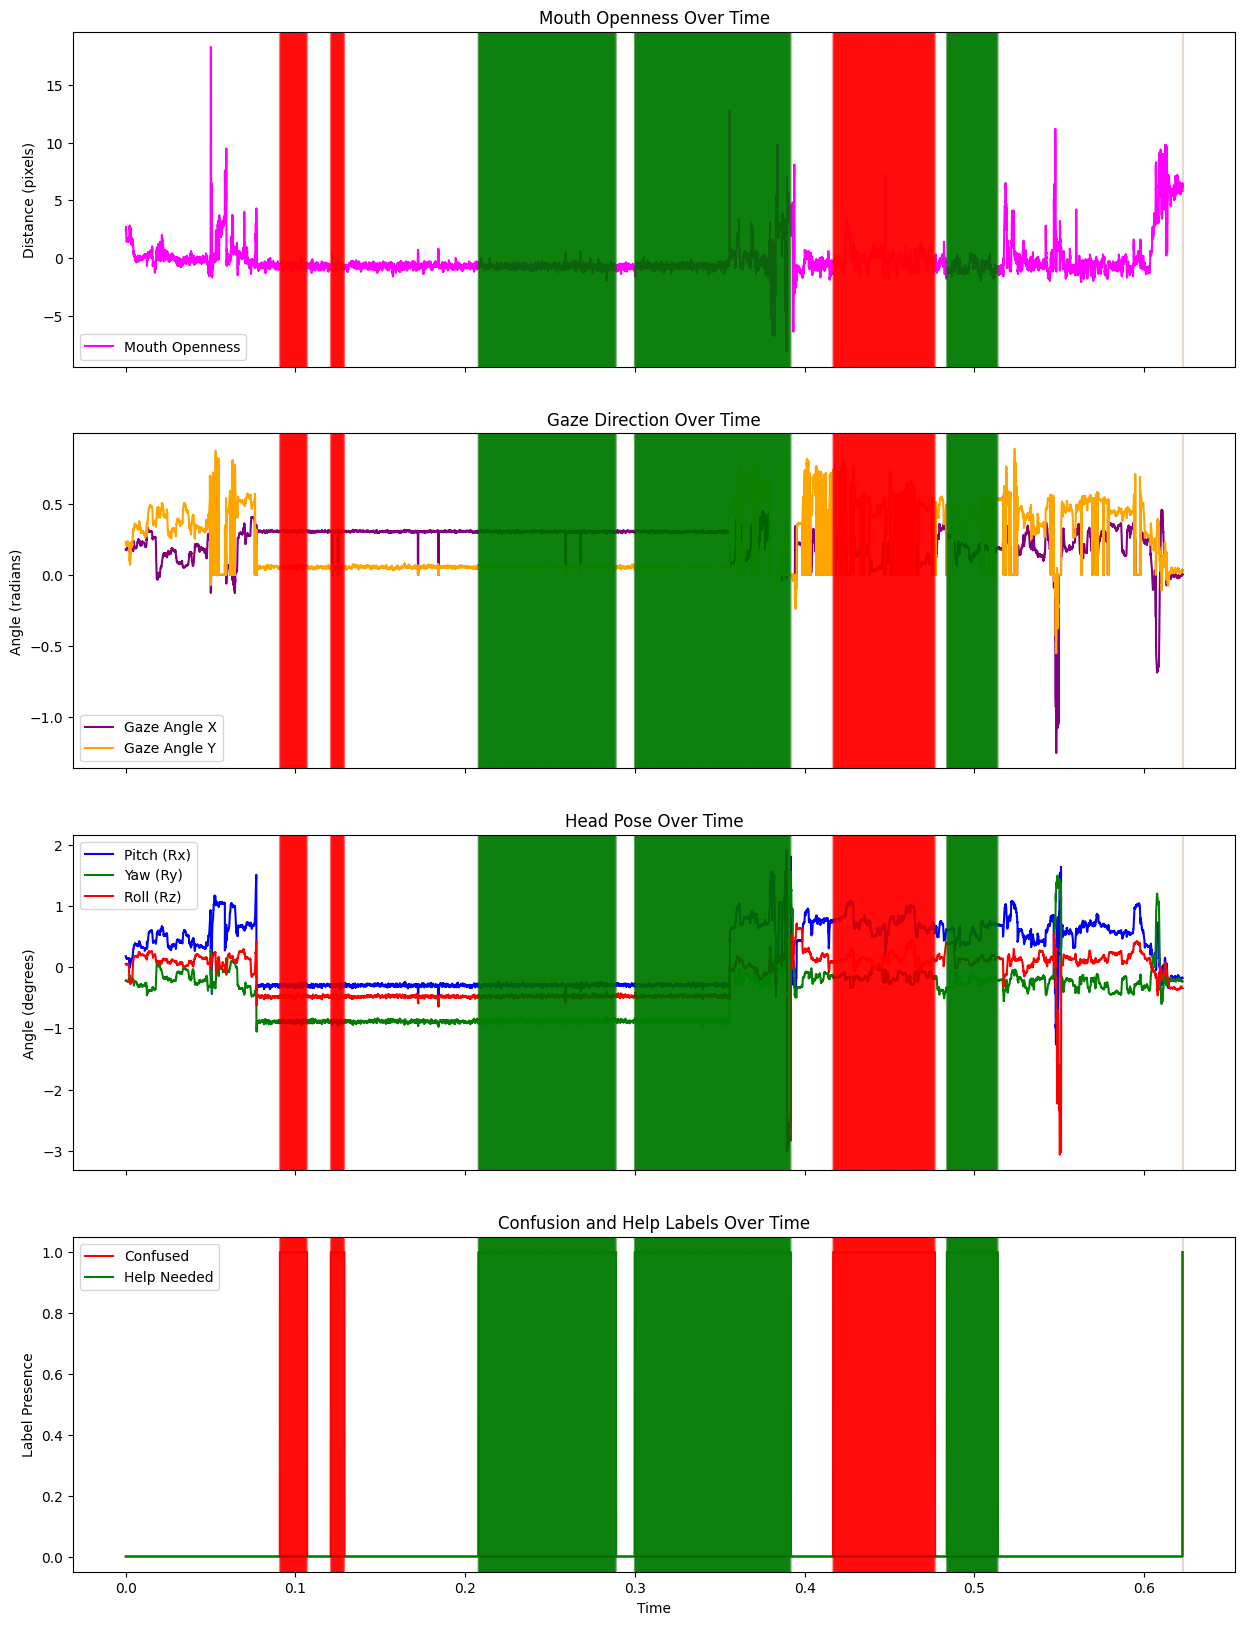

In [40]:
fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

# Facial Landmarks (e.g., mouth openness)
axs[0].plot(df['timestamp'], df['Y_66'] - df['Y_62'], label='Mouth Openness', color='magenta')
axs[0].set_title('Mouth Openness Over Time')
axs[0].set_ylabel('Distance (pixels)')
axs[0].legend()

# Gaze Direction
axs[1].plot(df['timestamp'], df['gaze_angle_x'], label='Gaze Angle X', color='purple')
axs[1].plot(df['timestamp'], df['gaze_angle_y'], label='Gaze Angle Y', color='orange')
axs[1].set_title('Gaze Direction Over Time')
axs[1].set_ylabel('Angle (radians)')
axs[1].legend()

# Head Pose
axs[2].plot(df['timestamp'], df['pose_Rx'], label='Pitch (Rx)', color='blue')
axs[2].plot(df['timestamp'], df['pose_Ry'], label='Yaw (Ry)', color='green')
axs[2].plot(df['timestamp'], df['pose_Rz'], label='Roll (Rz)', color='red')
axs[2].set_title('Head Pose Over Time')
axs[2].set_ylabel('Angle (degrees)')
axs[2].legend()

# 'Confused' and 'Help' Labels
axs[3].plot(df['timestamp'], df['confused'].astype(int), label='Confused', color='red')
axs[3].plot(df['timestamp'], df['help'].astype(int), label='Help Needed', color='green')
axs[3].set_title('Confusion and Help Labels Over Time')
axs[3].set_ylabel('Label Presence')
axs[3].set_xlabel('Time')
axs[3].legend()

# Highlight 'confused' and 'help' periods across all plots
for ax in axs:
    for idx, row in df[df['confused']].iterrows():
        ax.axvline(x=row['timestamp'], color='red', alpha=0.05)
    for idx, row in df[df['help']].iterrows():
        ax.axvline(x=row['timestamp'], color='green', alpha=0.05)

plt.show()


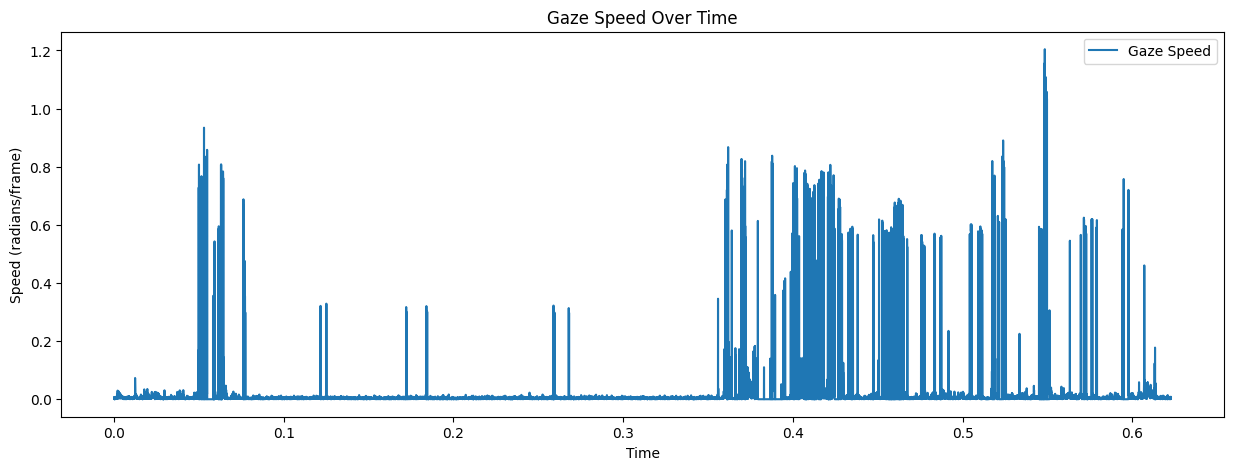

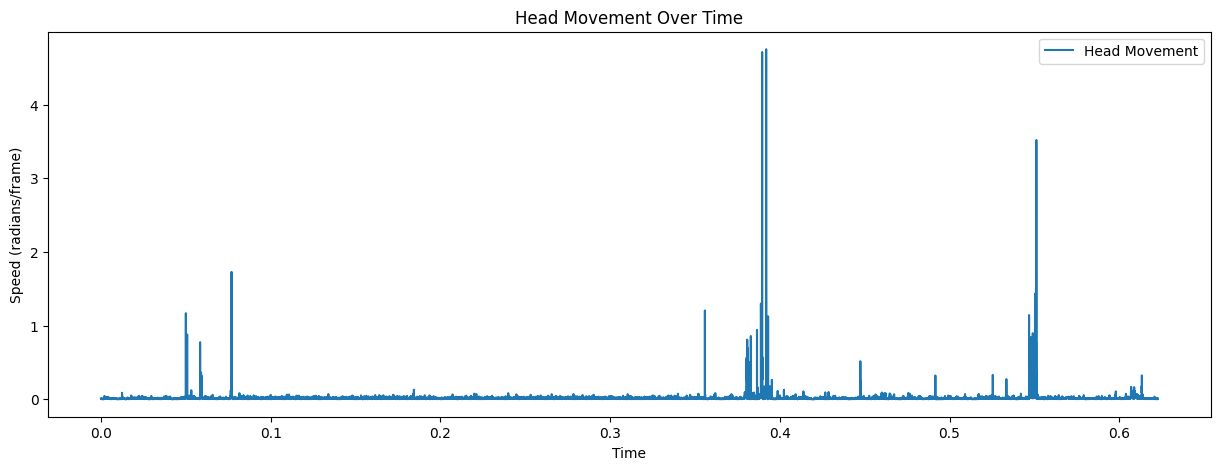

In [48]:
df['gaze_speed'] = np.sqrt(df['gaze_angle_x'].diff()**2 + df['gaze_angle_y'].diff()**2)
df['head_movement'] = np.sqrt(df['pose_Rx'].diff()**2 + df['pose_Ry'].diff()**2 + df['pose_Rz'].diff()**2)

plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['gaze_speed'], label='Gaze Speed')
plt.xlabel('Time')
plt.ylabel('Speed (radians/frame)')
plt.title('Gaze Speed Over Time')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['head_movement'], label='Head Movement')
plt.xlabel('Time')
plt.ylabel('Speed (radians/frame)')
plt.title('Head Movement Over Time')
plt.legend()
plt.show()


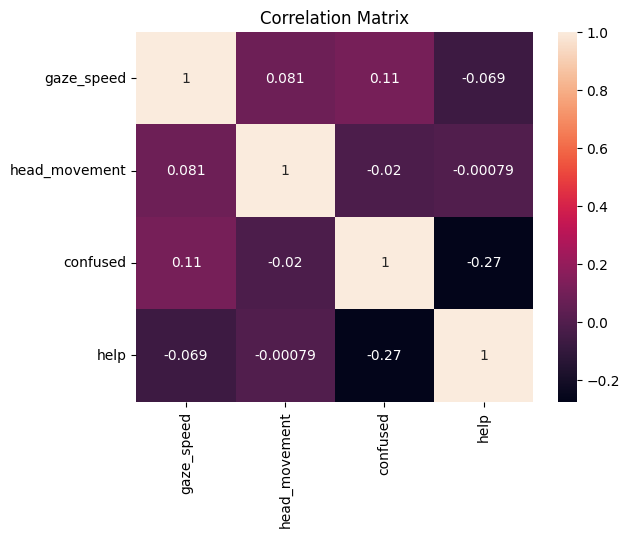

In [47]:
# Select features of interest
features = ['gaze_speed', 'head_movement', 'confused', 'help']

# Compute correlation matrix
corr_matrix = df[features].corr()

# Visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()
